In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Activation, Dropout, Conv1D, Conv1DTranspose, MaxPooling1D, concatenate, Concatenate, LSTM, Dense, SimpleRNN, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LayerNormalization, Dropout, MultiHeadAttention

# import sounddevice as sd
import os
from scipy.signal import butter, filtfilt
from scipy.signal import resample
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2023-05-14 07:43:32.527778: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
try:
 device_name = os.environ['COLAB_TPU_ADDR']
 TPU_ADDRESS = 'grpc://' + device_name
 print('Found TPU at: {}'.format(TPU_ADDRESS))
except KeyError:
 print('TPU not found')

gpu=tf.test.gpu_device_name()
if gpu=="":
  print("Computador sem GPU.")
else:
  print("Computador com GPU:",tf.test.gpu_device_name())
  from tensorflow.python.client import device_lib
  devices=device_lib.list_local_devices()
  print("Dispositivos:",[x.physical_device_desc for x in devices if x.physical_device_desc!=""])
print()

!lsb_release -a | grep "Description" #imprime qual é o sistema operacional
!echo

!cat /proc/cpuinfo | grep -E "model name|core" #especificações de CPU
!echo 

!cat /proc/meminfo  | grep "Mem" #especificações de RAM

TPU not found
Computador com GPU: /device:GPU:0
Dispositivos: ['device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1']



2023-05-14 07:43:47.638164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-14 07:43:48.097340: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-14 07:43:48.097487: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

No LSB modules are available.
Description:	Ubuntu 20.04.5 LTS

model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 0
cpu cores	: 6
model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 1
cpu cores	: 6
model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 2
cpu cores	: 6
model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 3
cpu cores	: 6
model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 4
cpu cores	: 6
model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 5
cpu cores	: 6

MemTotal:       16334184 kB
MemFree:        11077976 kB
MemAvailable:   13531528 kB


In [3]:
def undersample_signal_with_antialiasing(sound, orig_sr, desired_sr):
    
    new_sound = sound.copy()
    
    nyq = 0.5 * orig_sr
    cutoff_freq = desired_sr /2
    order = 6
    normal_cutoff = cutoff_freq / nyq

    # Compute the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    sound = filtfilt(b, a, new_sound)

    target_size = int(len(new_sound)*desired_sr/orig_sr)
    downsampled_signal = resample(new_sound, target_size)

    return downsampled_signal

In [4]:
def get_sounds_from_folder(path):
    
    max_depth = 3  # replace with the maximum depth of subfolders to search

    sound_list = []

    for root, dirs, files in os.walk(path):
        depth = root[len(path) + len(os.path.sep):].count(os.path.sep)
        if depth < max_depth:
            for file in files:
                if file.endswith('.bin'):#or file.endswith('.bin'):
                    wav_path = os.path.join(root, file)
                    sound_list.append(wav_path)
    
    return sound_list

In [5]:
def load_sound_from_bin(bin_path):
    # Carrega arquivo inteiro formato DOS
    # de nome contido na string str na variável x

    # with open(bin_path, 'rb') as f:
    #     x = np.fromfile(f, dtype=np.uint16)

    # supu = 2 ** 16  # 'supremo' unsigned
    # supc = 2 ** 15  # 'supremo' complemento de dois

    # nx = len(x)
    # x = 256 * x[1:nx:2] + x[0:nx:2]
    # i = np.where(x >= supc)[0]  # amostras que devem ser complementadas
    # x[i] = x[i] - supu

    # # return x, i
    # return uint16_to_int16(x)

    with open(bin_path, 'rb') as f:
        # Read the binary data as a string
        data = f.read()

    # Convert the string to a numpy int16 array
    array = np.frombuffer(data, dtype=np.int16)
    return array.astype(np.float32) / 32768.0

In [6]:
def add_white_gaussian_noise(signal, snr):
    # Calculate the signal power and convert to dB
    signal_power = np.mean(signal**2)
    signal_power_db = 10 * np.log10(signal_power)

    # Calculate the noise power required for the specified SNR and convert to linear scale
    noise_power_db = signal_power_db - snr
    noise_power = 10**(noise_power_db / 10)

    # Generate random noise with the required power and add it to the signal
    noise = np.random.normal(0, np.sqrt(noise_power), len(signal))
    noisy_signal = signal + noise

    return noisy_signal

In [7]:
def calculate_snr(clean_signal, noisy_signal):
    """
    Calculate the signal-to-noise ratio (SNR) in dB between a clean signal and a noisy signal.
    
    Args:
    clean_signal (numpy array): clean signal of shape (N, 1)
    noisy_signal (numpy array): noisy signal of shape (N, 1)
    
    Returns:
    snr_db (float): signal-to-noise ratio (SNR) in dB
    """
    clean_signal = clean_signal.reshape(-1, 1)
    noisy_signal = noisy_signal.reshape(-1, 1)
    
    # Calculate the power of the clean signal
    clean_power = np.mean(clean_signal ** 2)
    
    # Calculate the power of the noise signal
    noise_signal = noisy_signal - clean_signal
    noise_power = np.mean(noise_signal ** 2)
    
    # Calculate the SNR in dB
    snr_db = 10 * np.log10(clean_power / noise_power)
    
    return snr_db

In [8]:
def calculate_snrseg(clean_signal, noisy_signal, segment_size):
    """
    Calculate the signal-to-noise ratio (SNR) using the SNRseg metric between a clean signal and a noisy signal.
    
    Args:
    clean_signal (numpy array): clean signal of shape (N, 1)
    noisy_signal (numpy array): noisy signal of shape (N, 1)
    segment_size (int): size of each segment
    
    Returns:
    snr_db (float): signal-to-noise ratio (SNR) using the SNRseg metric
    """
    clean_signal = clean_signal.reshape(-1,1)
    noisy_signal = noisy_signal.reshape(-1,1)
    
    # Calculate the number of segments
    num_segments = int(np.floor(len(clean_signal) / segment_size))
    
    # Calculate the power of the clean signal
    clean_power = np.mean(clean_signal ** 2)
    
    # Initialize the noise power and segment count
    noise_power = 0
    segment_count = 0
    
    # Calculate the power of the noise signal for each segment
    for i in range(num_segments):
        segment_start = i * segment_size
        segment_end = (i+1) * segment_size
        noise_signal = noisy_signal[segment_start:segment_end] - clean_signal[segment_start:segment_end]
        noise_power += np.mean(noise_signal ** 2)
        segment_count += 1
        
    # Calculate the average noise power over all segments
    noise_power = noise_power / segment_count
    
    # Calculate the SNR using the SNRseg metric
    snr_db = 10 * np.log10(clean_power / noise_power)
    
    return snr_db

In [9]:
f_list = get_sounds_from_folder('./labeled16kHzspeech')

In [10]:
sound_array_clean = np.empty((len(f_list), 256), np.float32)
sound_array_noisy = np.empty((len(f_list), 256), np.float32)

for i, f in enumerate(f_list[:3000]):
    print('Loading file {}'.format(i))
    sound = load_sound_from_bin(f)
    sound = undersample_signal_with_antialiasing(sound, 16000, 8000)
    sound_array_clean = np.append(sound_array_clean, sound[:len(sound) // 256 * 256].reshape(-1, 256), axis=0)
    noisy_sound = add_white_gaussian_noise(sound.copy(), np.random.randint(-7, 20, size=(1,)[0]))
    sound_array_noisy = np.append(sound_array_noisy, noisy_sound[:len(noisy_sound) // 256 * 256].reshape(-1, 256), axis=0)

Loading file 0
Loading file 1
Loading file 2
Loading file 3
Loading file 4
Loading file 5
Loading file 6
Loading file 7
Loading file 8
Loading file 9
Loading file 10
Loading file 11
Loading file 12
Loading file 13
Loading file 14
Loading file 15
Loading file 16
Loading file 17
Loading file 18
Loading file 19
Loading file 20
Loading file 21
Loading file 22
Loading file 23
Loading file 24
Loading file 25
Loading file 26
Loading file 27
Loading file 28
Loading file 29
Loading file 30
Loading file 31
Loading file 32
Loading file 33
Loading file 34
Loading file 35
Loading file 36
Loading file 37
Loading file 38
Loading file 39
Loading file 40
Loading file 41
Loading file 42
Loading file 43
Loading file 44
Loading file 45
Loading file 46
Loading file 47
Loading file 48
Loading file 49
Loading file 50
Loading file 51
Loading file 52
Loading file 53
Loading file 54
Loading file 55
Loading file 56
Loading file 57
Loading file 58
Loading file 59
Loading file 60
Loading file 61
Loading file 62
Lo

Loading file 496
Loading file 497
Loading file 498
Loading file 499
Loading file 500
Loading file 501
Loading file 502
Loading file 503
Loading file 504
Loading file 505
Loading file 506
Loading file 507
Loading file 508
Loading file 509
Loading file 510
Loading file 511
Loading file 512
Loading file 513
Loading file 514
Loading file 515
Loading file 516
Loading file 517
Loading file 518
Loading file 519
Loading file 520
Loading file 521
Loading file 522
Loading file 523
Loading file 524
Loading file 525
Loading file 526
Loading file 527
Loading file 528
Loading file 529
Loading file 530
Loading file 531
Loading file 532
Loading file 533
Loading file 534
Loading file 535
Loading file 536
Loading file 537
Loading file 538
Loading file 539
Loading file 540
Loading file 541
Loading file 542
Loading file 543
Loading file 544
Loading file 545
Loading file 546
Loading file 547
Loading file 548
Loading file 549
Loading file 550
Loading file 551
Loading file 552
Loading file 553
Loading file 5

Loading file 983
Loading file 984
Loading file 985
Loading file 986
Loading file 987
Loading file 988
Loading file 989
Loading file 990
Loading file 991
Loading file 992
Loading file 993
Loading file 994
Loading file 995
Loading file 996
Loading file 997
Loading file 998
Loading file 999
Loading file 1000
Loading file 1001
Loading file 1002
Loading file 1003
Loading file 1004
Loading file 1005
Loading file 1006
Loading file 1007
Loading file 1008
Loading file 1009
Loading file 1010
Loading file 1011
Loading file 1012
Loading file 1013
Loading file 1014
Loading file 1015
Loading file 1016
Loading file 1017
Loading file 1018
Loading file 1019
Loading file 1020
Loading file 1021
Loading file 1022
Loading file 1023
Loading file 1024
Loading file 1025
Loading file 1026
Loading file 1027
Loading file 1028
Loading file 1029
Loading file 1030
Loading file 1031
Loading file 1032
Loading file 1033
Loading file 1034
Loading file 1035
Loading file 1036
Loading file 1037
Loading file 1038
Loading f

Loading file 1442
Loading file 1443
Loading file 1444
Loading file 1445
Loading file 1446
Loading file 1447
Loading file 1448
Loading file 1449
Loading file 1450
Loading file 1451
Loading file 1452
Loading file 1453
Loading file 1454
Loading file 1455
Loading file 1456
Loading file 1457
Loading file 1458
Loading file 1459
Loading file 1460
Loading file 1461
Loading file 1462
Loading file 1463
Loading file 1464
Loading file 1465
Loading file 1466
Loading file 1467
Loading file 1468
Loading file 1469
Loading file 1470
Loading file 1471
Loading file 1472
Loading file 1473
Loading file 1474
Loading file 1475
Loading file 1476
Loading file 1477
Loading file 1478
Loading file 1479
Loading file 1480
Loading file 1481
Loading file 1482
Loading file 1483
Loading file 1484
Loading file 1485
Loading file 1486
Loading file 1487
Loading file 1488
Loading file 1489
Loading file 1490
Loading file 1491
Loading file 1492
Loading file 1493
Loading file 1494
Loading file 1495
Loading file 1496
Loading fi

Loading file 1900
Loading file 1901
Loading file 1902
Loading file 1903
Loading file 1904
Loading file 1905
Loading file 1906
Loading file 1907
Loading file 1908
Loading file 1909
Loading file 1910
Loading file 1911
Loading file 1912
Loading file 1913
Loading file 1914
Loading file 1915
Loading file 1916
Loading file 1917
Loading file 1918
Loading file 1919
Loading file 1920
Loading file 1921
Loading file 1922
Loading file 1923
Loading file 1924
Loading file 1925
Loading file 1926
Loading file 1927
Loading file 1928
Loading file 1929
Loading file 1930
Loading file 1931
Loading file 1932
Loading file 1933
Loading file 1934
Loading file 1935
Loading file 1936
Loading file 1937
Loading file 1938
Loading file 1939
Loading file 1940
Loading file 1941
Loading file 1942
Loading file 1943
Loading file 1944
Loading file 1945
Loading file 1946
Loading file 1947
Loading file 1948
Loading file 1949
Loading file 1950
Loading file 1951
Loading file 1952
Loading file 1953
Loading file 1954
Loading fi

Loading file 2357
Loading file 2358
Loading file 2359
Loading file 2360
Loading file 2361
Loading file 2362
Loading file 2363
Loading file 2364
Loading file 2365
Loading file 2366
Loading file 2367
Loading file 2368
Loading file 2369
Loading file 2370
Loading file 2371
Loading file 2372
Loading file 2373
Loading file 2374
Loading file 2375
Loading file 2376
Loading file 2377
Loading file 2378
Loading file 2379
Loading file 2380
Loading file 2381
Loading file 2382
Loading file 2383
Loading file 2384
Loading file 2385
Loading file 2386
Loading file 2387
Loading file 2388
Loading file 2389
Loading file 2390
Loading file 2391
Loading file 2392
Loading file 2393
Loading file 2394
Loading file 2395
Loading file 2396
Loading file 2397
Loading file 2398
Loading file 2399
Loading file 2400
Loading file 2401
Loading file 2402
Loading file 2403
Loading file 2404
Loading file 2405
Loading file 2406
Loading file 2407
Loading file 2408
Loading file 2409
Loading file 2410
Loading file 2411
Loading fi

Loading file 2813
Loading file 2814
Loading file 2815
Loading file 2816
Loading file 2817
Loading file 2818
Loading file 2819
Loading file 2820
Loading file 2821
Loading file 2822
Loading file 2823
Loading file 2824
Loading file 2825
Loading file 2826
Loading file 2827
Loading file 2828
Loading file 2829
Loading file 2830
Loading file 2831
Loading file 2832
Loading file 2833
Loading file 2834
Loading file 2835
Loading file 2836
Loading file 2837
Loading file 2838
Loading file 2839
Loading file 2840
Loading file 2841
Loading file 2842
Loading file 2843
Loading file 2844
Loading file 2845
Loading file 2846
Loading file 2847
Loading file 2848
Loading file 2849
Loading file 2850
Loading file 2851
Loading file 2852
Loading file 2853
Loading file 2854
Loading file 2855
Loading file 2856
Loading file 2857
Loading file 2858
Loading file 2859
Loading file 2860
Loading file 2861
Loading file 2862
Loading file 2863
Loading file 2864
Loading file 2865
Loading file 2866
Loading file 2867
Loading fi

In [16]:
# Define the proportion of data to use for training, validation, and test
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2

sound_array_clean = sound_array_clean.reshape(sound_array_clean.shape[0], sound_array_clean.shape[1], 1)
sound_array_noisy = sound_array_noisy.reshape(sound_array_noisy.shape[0], sound_array_noisy.shape[1], 1)

sound_array_clean = np.nan_to_num(sound_array_clean, nan=0.0)
sound_array_noisy = np.nan_to_num(sound_array_noisy, nan=0.0)

In [17]:
# Split the data and labels into training and test sets
X_train, X_test, y_train, y_test = train_test_split(sound_array_noisy, sound_array_clean, test_size=test_prop, random_state=42)

# Split the training data and labels into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_prop/train_prop, random_state=42)

In [21]:
X_train = np.clip(X_train, -1, 1)
X_val = np.clip(X_val, -1, 1)
y_train = np.clip(y_train, -1, 1)
y_val = np.clip(y_val, -1, 1)

In [22]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(100387, 256, 1)
(100387, 256, 1)
(50194, 256, 1)
(50194, 256, 1)


In [23]:
print(np.max(X_train))
print(np.max(y_train))
print(np.max(X_val))
print(np.max(y_val))

1.0
1.0
1.0
1.0


In [24]:
print(np.min(X_train))
print(np.min(y_train))
print(np.min(X_val))
print(np.min(y_val))

-1.0
-1.0
-1.0
-1.0


In [25]:
# Define the input shape
max_norm_value=0.2

input_shape = (256, 1)

# model = Sequential()
# model.add(Conv1D(128, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
# model.add(Conv1D(32, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
# model.add(Conv1D(16, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
# model.add(Conv1DTranspose(16, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
# model.add(Conv1DTranspose(32, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
# model.add(Conv1DTranspose(128, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
# model.add(Conv1D(1, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='sigmoid', padding='same'))

# model.compile(optimizer='adam', loss='mean_squared_logarithmic_error')

# # Define the input layer
# inputs = Input(shape=input_shape)

# # Define the convolutional layers
# x = Conv1D(filters=16, kernel_size=3, strides=1, padding='same')(inputs)
# x = Activation('relu')(x)
# x = Conv1D(filters=16, kernel_size=3, strides=1, padding='same')(x)
# x = Activation('relu')(x)

# # Add more convolutional layers
# x = Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(x)
# x = Activation('relu')(x)
# x = Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(x)
# x = Activation('relu')(x)

# # Add a dropout layer for regularization
# x = Dropout(0.2)(x)

# # Add more convolutional layers
# x = Conv1D(filters=64, kernel_size=3, strides=1, padding='same')(x)
# x = Activation('relu')(x)
# x = Conv1D(filters=64, kernel_size=3, strides=1, padding='same')(x)
# x = Activation('relu')(x)

# # Add a dropout layer for regularization
# x = Dropout(0.2)(x)

# # Add more convolutional layers
# x = Conv1D(filters=128, kernel_size=3, strides=1, padding='same')(x)
# x = Activation('relu')(x)
# x = Conv1D(filters=128, kernel_size=3, strides=1, padding='same')(x)
# x = Activation('relu')(x)

# # Add a dropout layer for regularization
# x = Dropout(0.2)(x)

# # Define the output layer
# x = Conv1D(filters=1, kernel_size=3, strides=1, padding='same')(x)
# outputs = Activation('linear')(x)

# # Define the model
# model = Model(inputs=inputs, outputs=outputs)

# Compile the model
# model.compile(optimizer='adam', loss='mse')

#Modelo utilizado

def unet(input_shape=(256, 1)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv1D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv1D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    conv2 = Conv1D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv1D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    conv3 = Conv1D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv1D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling1D(pool_size=2)(conv3)

    # Bridge
    conv4 = Conv1D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv1D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = Conv1DTranspose(256, kernel_size=2, strides=2, padding='same')(conv4)
    up5 = Concatenate()([conv3, up5])
    conv5 = Conv1D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv1D(256, 3, activation='relu', padding='same')(conv5)

    up6 = Conv1DTranspose(128, kernel_size=2, strides=2, padding='same')(conv5)
    up6 = Concatenate()([conv2, up6])
    conv6 = Conv1D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv1D(128, 3, activation='relu', padding='same')(conv6)

    up7 = Conv1DTranspose(64, kernel_size=2, strides=2, padding='same')(conv6)
    up7 = Concatenate()([conv1, up7])
    conv7 = Conv1D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv1D(64, 3, activation='relu', padding='same')(conv7)

    # Output
    outputs = Conv1D(1, 1, activation='tanh')(conv7)
    outputs = Activation('tanh')(outputs)

    # Model definition
    model = Model(inputs, outputs)
    return model

def my_model():
  kernel_size = 7

  net_input = Input(shape=input_shape)
  conv1 = Conv1D(64, kernel_size, activation = 'relu', padding = 'same')(net_input)
  conv1 = Conv1D(64, kernel_size, activation = 'relu', padding = 'same')(conv1)
  pool1 = MaxPooling1D(pool_size=2)(conv1)

  conv2 = Conv1D(128, kernel_size, activation = 'relu', padding = 'same')(pool1)
  conv2 = Conv1D(128, kernel_size, activation = 'relu', padding = 'same')(conv2)
  pool2 = MaxPooling1D(pool_size=2)(conv2)

  conv3 = Conv1D(256, kernel_size, activation = 'relu', padding = 'same')(pool2)
  conv3 = Conv1D(256, kernel_size, activation = 'relu', padding = 'same')(conv3)
  pool3 = MaxPooling1D(pool_size=2)(conv3)

  up7 = Conv1D(256, 2, activation = 'relu', padding = 'same')(Conv1DTranspose(1, 1, strides=2)(pool3))
  merge7 = concatenate([conv3,up7], axis = 2)

  conv7 = Conv1D(256, kernel_size, activation = 'relu', padding = 'same')(merge7)
  conv7 = Conv1D(256, kernel_size, activation = 'relu', padding = 'same')(conv7)

  up8 = Conv1D(128, 2, activation = 'relu', padding = 'same')(Conv1DTranspose(1, 1, strides=2)(conv7))
  merge8 = concatenate([conv2,up8], axis = 2)
  conv8 = Conv1D(128, kernel_size, activation = 'relu', padding = 'same')(merge8)
  conv8 = Conv1D(128, kernel_size, activation = 'relu', padding = 'same')(conv8)

  up9 = Conv1D(64, 2, activation = 'relu', padding = 'same')(Conv1DTranspose(1, 1, strides=2)(conv8))
  merge9 = concatenate([conv1,up9], axis = 2)

  conv9 = Conv1D(64, kernel_size, activation = 'relu', padding = 'same')(merge9)
  conv9 = Conv1D(1, kernel_size, activation = 'tanh', padding = 'same')(conv9)

  model = Model(net_input, conv9)

  return model

def mixed():
  input_layer = Input(shape=(256, 1))

  # Encoding layers
  conv1 = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(input_layer)
  pool1 = MaxPooling1D(pool_size=2)(conv1)
  conv2 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(pool1)
  pool2 = MaxPooling1D(pool_size=2)(conv2)
  conv3 = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(pool2)
  pool3 = MaxPooling1D(pool_size=2)(conv3)

  # LSTM layers
  lstm1 = LSTM(units=128, return_sequences=True)(pool3)
  lstm2 = LSTM(units=128, return_sequences=True)(lstm1)

  # Decoding layers
  up1 = Conv1DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(lstm2)
  concat1 = Concatenate()([up1, conv3])
  up2 = Conv1DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(concat1)
  concat2 = Concatenate()([up2, conv2])
  up3 = Conv1DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(concat2)
  concat3 = Concatenate()([up3, conv1])

  # Output layer
  outputs = Conv1D(filters=1, kernel_size=1, activation='tanh')(concat3)

  return Model(inputs=input_layer, outputs=outputs)
# model.compile(optimizer='adam', loss='mse')
def mixed_mha():
  kernel_size = 7


  input_layer = Input(shape=(256, 1))

  # Encoding layers
  conv1 = Conv1D(filters=32, kernel_size=kernel_size, padding='same', activation='relu')(input_layer)
  pool1 = MaxPooling1D(pool_size=2)(conv1)
  conv2 = Conv1D(filters=64, kernel_size=kernel_size, padding='same', activation='relu')(pool1)
  pool2 = MaxPooling1D(pool_size=2)(conv2)
  conv3 = Conv1D(filters=128, kernel_size=kernel_size, padding='same', activation='relu')(pool2)
  pool3 = MaxPooling1D(pool_size=2)(conv3)

  # Add layer normalization and dropout
  pool3 = LayerNormalization()(pool3)
  pool3 = Dropout(0.2)(pool3)

  # Multi-Head Attention layer
  num_heads = 4
  key_dim = 32
  attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(pool3, pool3, pool3)
  attn_output = LayerNormalization()(attn_output)
  attn_output = Dropout(0.2)(attn_output)

  # LSTM layers
  lstm1 = LSTM(units=128, return_sequences=True)(attn_output)
  lstm2 = LSTM(units=128, return_sequences=True)(lstm1)

  # Add layer normalization and dropout
  lstm2 = LayerNormalization()(lstm2)
  lstm2 = Dropout(0.2)(lstm2)

  # Decoding layers
  up1 = Conv1DTranspose(filters=128, kernel_size=kernel_size, strides=2, padding='same', activation='relu')(lstm2)
  concat1 = Concatenate()([up1, conv3])
  up2 = Conv1DTranspose(filters=64, kernel_size=kernel_size, strides=2, padding='same', activation='relu')(concat1)
  concat2 = Concatenate()([up2, conv2])
  up3 = Conv1DTranspose(filters=32, kernel_size=kernel_size, strides=2, padding='same', activation='relu')(concat2)
  concat3 = Concatenate()([up3, conv1])

  # Output layer
  outputs = Conv1D(filters=1, kernel_size=1, activation='tanh')(concat3)

  return Model(inputs=input_layer, outputs=outputs)


In [26]:
class PlotLossesCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.epochs = 0
        self.fig, self.ax = plt.subplots()

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.epochs += 1

        self.ax.clear()
        self.ax.plot(range(1, self.epochs+1), self.losses, label='training')
        self.ax.plot(range(1, self.epochs+1), self.val_losses, label='validation')
        self.ax.legend()
        self.ax.set_xlabel('Epoch')
        self.ax.set_ylabel('Loss')
        self.ax.set_title('Training and Validation Loss')

In [37]:
# GPU CODE
# model = mixed()
model = mixed_mha()
model.compile(optimizer='adam', loss='mse')
model.summary()
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(),
#     loss=tf.keras.losses.mse
# )
model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_val, y_val), callbacks=[PlotLossesCallback()])
# model.fit(
#   X_train, y_train,
#   epochs=15,
#   verbose=True,
#   validation_data=(X_val, y_val),
#   batch_size=256
# )

score = model.evaluate(X_test, y_test, verbose=0)
print(score)
model.save('sample.h5')

# Generate some example training data
# x_train = np.random.normal(size=(1000, 256, 1))
# y_train = x_train + 0.1 * np.random.normal(size=(1000, 256, 1))

# Train the model
# model.fit(X_train, y_train, epochs=4, batch_size=128)

# Generate some example test data
# x_test = np.random.normal(size=(100, 256, 1))
# y_test = x_test + 0.1 * np.random.normal(size=(100, 256, 1))

# Evaluate the model on the test data
# loss = model.evaluate(X_test, y_test)

In [31]:
sound_array = load_sound_from_bin('./labeled16kHzspeech/BR_00400/BR_00400.balsen2.bin')
# sd.play(sound_array, 16000)
# sd.wait()

sound = undersample_signal_with_antialiasing(sound_array, 16000, 8000)
sound_array_clean = sound[:len(sound) // 256 * 256].reshape(-1, 256)
noisy_sound = add_white_gaussian_noise(sound.copy(), 5)
sound_array_noisy = noisy_sound[:len(noisy_sound) // 256 * 256].reshape(-1, 256, 1)

In [32]:
plt.plot(sound[3250:3500])

In [33]:
plt.plot(noisy_sound[3250:3500])

In [34]:
filtered = model.predict(sound_array_noisy)
filtered_sound = filtered.reshape(-1, 1)
plt.plot(filtered_sound[3250:3500])

In [35]:
print('SNR sinal ruidoso: {}'.format(calculate_snr(sound_array_clean, sound_array_noisy)))
print('SNR sinal filtrado: {}'.format(calculate_snr(sound_array_clean, filtered)))

In [36]:
print('SNRseg sinal ruidoso: {}'.format(calculate_snrseg(sound_array_clean, sound_array_noisy, 256)))
print('SNRseg sinal filtrado: {}'.format(calculate_snrseg(sound_array_clean, filtered, 256)))

In [ ]:
import scipy.io.wavfile as wavfile

# Set the sampling rate and audio data
sampling_rate = 8000


s = 32768.0*sound_array_clean.copy()
s = s.reshape(-1, 1).astype(np.int16)

n = 32768.0*sound_array_noisy.copy()
n = n.reshape(-1, 1).astype(np.int16)

f = 32768.0*filtered.copy()
f = f.reshape(-1, 1).astype(np.int16)


# Save the audio data as a WAV file
wavfile.write('original.wav', sampling_rate, s)
wavfile.write('ruidoso.wav', sampling_rate, n)
wavfile.write('filtrado.wav', sampling_rate, f)

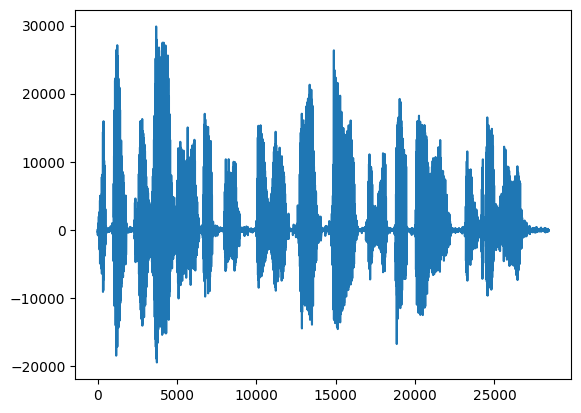

In [ ]:
plt.plot(f)

ValueError: ignored

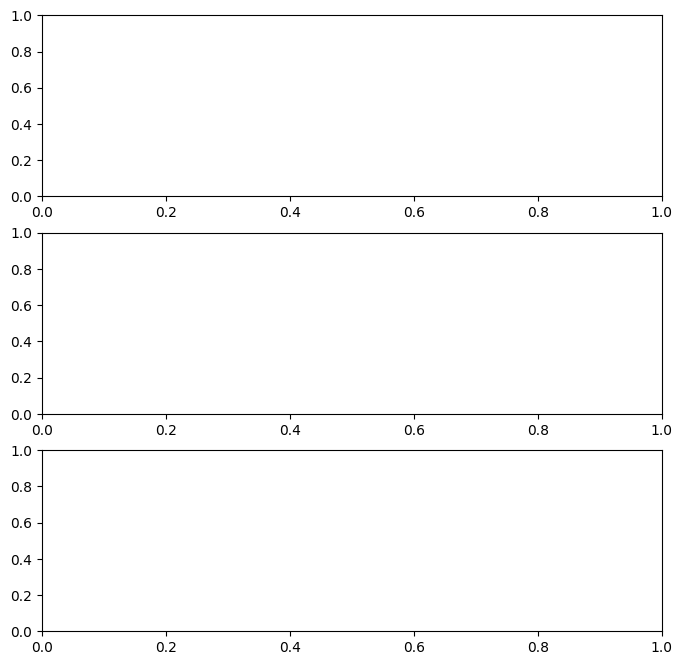

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Amostras do sinal
fs = 8000  # frequência de amostragem
N = 256  # número de amostras
t = np.arange(N) / fs  # vetor de tempo

# Sinal de exemplo: uma senoide de 1kHz com amplitude 1 e fase 0
f = 1000  # frequência do sinal
A = 1  # amplitude do sinal
phi = 0  # fase do sinal
x = filtered_sound[3250:3500]  # sinal amostrado

# Cálculo da DFT
X = np.fft.fft(x)  # DFT
X_mag = np.abs(X)  # magnitude
X_phase = np.angle(X)  # fase
f_axis = np.fft.fftfreq(N, 1/fs)  # eixo das frequências

# Plot do espectro de frequência
fig, axs = plt.subplots(3, 1, figsize=(8, 8))
axs[0].plot(t, x)
axs[0].set_xlabel('Tempo (s)')
axs[0].set_ylabel('Amplitude')
axs[1].stem(f_axis, X_mag)
axs[1].set_xlabel('Frequência (Hz)')
axs[1].set_ylabel('Magnitude')
axs[2].stem(f_axis, X_phase)
axs[2].set_xlabel('Frequência (Hz)')
axs[2].set_ylabel('Fase')
plt.show()